## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('/datasets/taxi.csv',index_col=[0],parse_dates=[0])

data.index = pd.to_datetime(data.index)
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

<b> Вывод: </b> Данные загружены и выполнено ресемплирование по одному часу

## Анализ

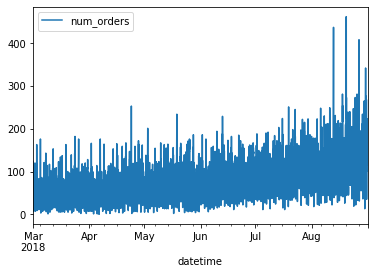

In [5]:
data.plot()

По данным видно что с каждым месяцем число заказов увеличивается. Если точнее, то в теплые месяца заказов из аэропорта больше. Август сильно отличается от марта, летом же все едут в отпуск

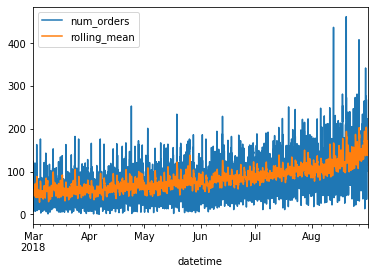

In [6]:
#вычисляем скользящее среднее

data['rolling_mean'] = data.rolling(12).mean()
data.plot()

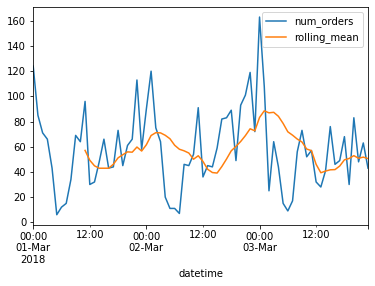

In [7]:
data1= data['2018-03-01':'2018-03-03']
data1.plot()

Text(0.5, 1.0, 'Seasonality')

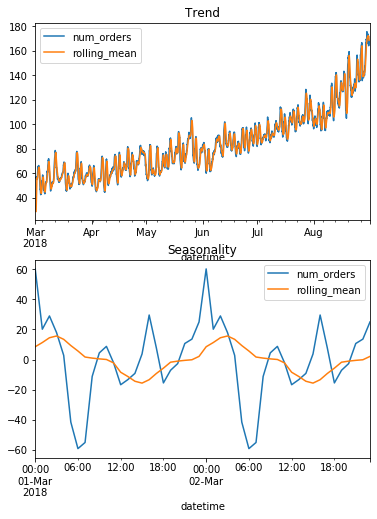

In [8]:
data = data.resample('1H').sum()

decomposed = seasonal_decompose(data) 

decomposed.seasonal=decomposed.seasonal['2018-03-01-00':'2018-03-02-23']


plt.figure(figsize=(6, 8))
plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(212)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

<b> Вывод: </b> В данных за 3 дня видна разница заказов ночью с дневными заказами, в 00:00 их намного больше. Спад происходит около 6:00

In [9]:
#Добавляем признаки

def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data, 5, 24)

In [10]:
data.head(30)

,num_orders,rolling_mean,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5
datetime,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,4,66.0,71.0,85.0,124.0,NaN
2018-03-01 05:00:00,6,NaN,3,5,43.0,66.0,71.0,85.0,124.0
2018-03-01 06:00:00,12,NaN,3,6,6.0,43.0,66.0,71.0,85.0
2018-03-01 07:00:00,15,NaN,3,7,12.0,6.0,43.0,66.0,71.0
2018-03-01 08:00:00,34,NaN,3,8,15.0,12.0,6.0,43.0,66.0


## Обучение

In [11]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

target_train = train['num_orders'] 
features_train = train.drop(['num_orders'],axis=1)
 
target_test = test['num_orders']
features_test = test.drop(['num_orders'],axis=1)


In [12]:
model=LinearRegression()
model.fit(features_train,target_train)
pred_test_linear = model.predict(features_test)
pred_train = model.predict(features_train)

print('RMSE обучающей выборки=',mean_squared_error(target_train,pred_train)**0.5 )

RMSE обучающей выборки= 30.66220309270589


In [13]:
#Подбор лучших гиперпараметров для Случайного леса
from sklearn.model_selection import TimeSeriesSplit

mse = make_scorer(mean_squared_error,greater_is_better=False)

tscv = TimeSeriesSplit()

parametrs = { 'n_estimators': range (10, 25, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

clf = RandomForestRegressor()
grid = GridSearchCV(clf,param_grid=parametrs, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
grid.fit(features_train, target_train)

print(grid.best_params_)

Fitting 3 folds for each of 336 candidates, totalling 1008 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:784: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1008 out of 1008 | elapsed:  1.5min finished


{'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 20}


In [14]:
model=RandomForestRegressor(max_depth = 11,min_samples_leaf = 3, min_samples_split = 4, n_estimators=20, random_state=None)
model.fit(features_train,target_train) 
pred_test_randomforest = model.predict(features_test)
pred_train = model.predict(features_train)

print('RMSE обучающей выборки=',mean_squared_error(target_train,pred_train)**0.5 )

RMSE обучающей выборки= 15.859258816614522


In [15]:
model = LGBMRegressor(n_estimators = 150,max_depth=50, random_state=None)
model.fit(features_train, target_train)

prediction_train=model.predict(features_train)
pred_test_lgbm=model.predict(features_test)
print('RMSE=',mean_squared_error(target_train,prediction_train)**0.5 )

RMSE= 13.531423856675163


## Тестирование

In [16]:
#Линейная регрессия

print('RMSE тестовой выборки=',mean_squared_error(target_test,pred_test_linear)**0.5 )

RMSE тестовой выборки= 50.2890192085309


In [17]:
#Случайный лес
print('RMSE тестовой выборки=',mean_squared_error(target_test,pred_test_randomforest)**0.5 )

RMSE тестовой выборки= 47.16625521340584


In [18]:
#LGBM
print('RMSE тестовой выборки=',mean_squared_error(target_test,pred_test_lgbm)**0.5 )

RMSE тестовой выборки= 44.07918491373053


<b> Вывод: </b> В результате обучения лучшее значение метрики на тестовой выборке показала модель градиентного бустинга = 44.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


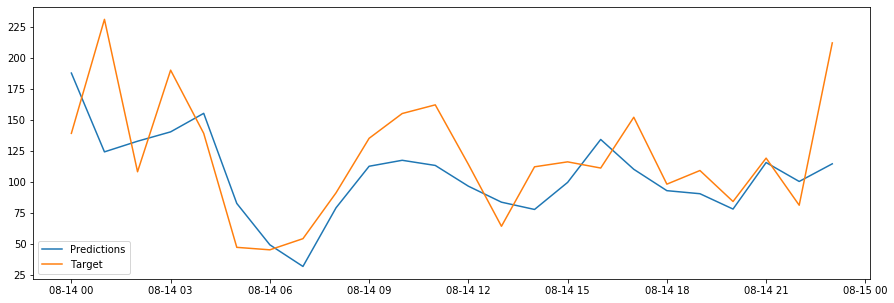

In [117]:
#сравнение факта и предсказаний

test['predictions']=pred_test_lgbm

test_plot=test['2018-08-14-00':'2018-08-14-23']


plt.figure(figsize=(15,5))
plt.plot(test_plot['predictions'], label='Predictions')
plt.plot(test_plot['num_orders'], label='Target')
plt.legend()

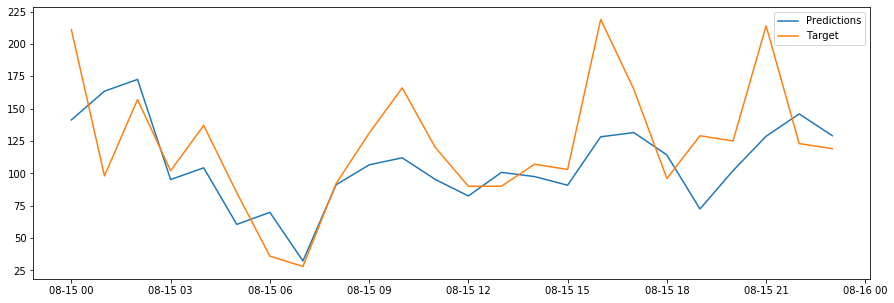

In [118]:
test_plot=test['2018-08-15-00':'2018-08-15-23']


plt.figure(figsize=(15,5))
plt.plot(test_plot['predictions'], label='Predictions')
plt.plot(test_plot['num_orders'], label='Target')
plt.legend()